In [ ]:
#default_exp math

# math

> This module defines various mathematical functions. 

In [ ]:
#export
import numpy, scipy
from jax import scipy as jsc
from jax import numpy as jnp
import jax
from abc import ABC, abstractmethod, abstractproperty
from jax import jit
from jax.lax import fori_loop

pi=jnp.pi

In [ ]:
#hide 
from matplotlib import pyplot
import seaborn

In [ ]:
def stable_log_expit(x):
    return -jnp.logaddexp(0, -x)
stable_log_expit(20)

DeviceArray(-2.0611537e-09, dtype=float32)

In [ ]:
#export

def correct_eigenvalues(eigvals, eigval_threshold=1e-5):
    """Replaces eigenvalues less than the specified threshold with the threshold value"""
    eigvals[eigvals<eigval_threshold]=eigval_threshold
    return eigvals

def make_positive_semidef(mat, min_eigval=1e-5):
    """Finds the nearest positive semidefinite matrix (with all eigenvalues greater than \
    a specified threshold) to a given symmetrix matrix with respect to the Frobenius norm. \
    Implemements Theorem 3.2 from  Cheng and Hingham, 1998 "A modified Cholesky algorithm \
    based on a symmetric indefinite factorization."
    
    ****
    **Arguments:**
    `mat` (N-by-N symmetric matrix)
    `min_eigval` (float): The minimum eigenvalue of the desired matrix.
    """
    eigvals, eigvecs=numpy.linalg.eigh(mat)
    eigvals=correct_eigenvalues(eigvals, min_eigval)
    fixed_mat=eigvecs@numpy.diag(eigvals)@numpy.linalg.inv(eigvecs)
    return fixed_mat

In [ ]:
#export
def log_expit(x):
    """Computes the log of the inverse logit function using the logsumexp trick."""
    stacked=jnp.stack([0*x, -x], axis=0)

    return -jsc.special.logsumexp(stacked, axis=0)

In [ ]:
print (log_expit(.5))
print (numpy.log(scipy.special.expit(.5)))


-0.474077
-0.47407698418010663


In [ ]:
#export

def compute_triangle_size(K):
    return int(((K-1)**2+K-1)/2)
def construct_K_rank_cholesky(diag, offdiag, M,K=3):
    chol=jnp.zeros((M,K))
    tri_max=compute_triangle_size(K)

    chol=chol.at[ jnp.diag_indices(K)].add(diag)
    chol=chol.at[jnp.tril_indices(K, -1,)].add(offdiag[:tri_max])

    x_ind=jnp.repeat(jnp.arange(K,M), repeats=K)
    y_ind=jnp.tile(jnp.arange(0,K),M-K)

    chol=chol.at[x_ind, y_ind].add(offdiag[tri_max:])
    return chol

def construct_K_rank_correlation_cholesky(offdiag, M,K=3):
    diag=numpy.ones(K)
    chol=construct_K_rank_cholesky(diag, offdiag,M,K)
    L=(numpy.sign(chol)* (chol**2/(chol**2).sum(1)[:,None])**.5)
    return L
    

In [ ]:

@jit
def factor_toeplitz_slow(U, eps=1e-6):
    """Factor a symmetric Toeplitz covariance matrix.
        
    **Arguments:**

            U(numpy.array): The first row of the covariance matrix

    **Returns:**

            triu: The upper triangular Cholesky matrix"""

    U=U.at[0].set(1+eps)
    u_k=U/U[0]**.5
    v_k=U/U[0]**.5
    v_k=v_k.at[0].set(0)
    
    Us=[u_k]
    
    for k in range(0,len(U)-1):
        # Find the right rotation
        sin_k=v_k[k+1]/u_k[k]
        cos_k=(1-sin_k**2)**.5
        #Shift u_k
        Zu=jnp.zeros(len(u_k))
#         Zu[1:]=u_k[:-1]
        Zu=Zu.at[1:].set(u_k[:-1])
        
        u_k=((Zu-sin_k*v_k)/cos_k)
        v_k=(-sin_k*u_k+cos_k*v_k)
        Us.append(u_k)
    return jnp.array(Us)

In [ ]:
#export
@jit
def bareiss_onestep(k, a):
    """Compute a single iteration of the Bareiss algorithm.
    
    ****
    **Arguments:**
    
    `k` (int): The number of the current iteration
    
    `a` (tuple): (u_k, v_k, Us) """
    # unpack the inputs
    u_k,v_k,Us=a
    
    # Find the right rotation
    sin_k=v_k[k+1]/u_k[k]
    cos_k=(1-sin_k**2)**.5
    
    #Shift u_k
    Zu=jnp.zeros(len(u_k))
    Zu=Zu.at[1:].set(u_k[:-1])

    u_k=((Zu-sin_k*v_k)/cos_k)
    v_k=(-sin_k*u_k+cos_k*v_k)

    Us=Us.at[k+1].set(u_k)

    return (u_k,v_k,Us)
    
@jit
def factor_toeplitz(U, eps=1e-6):
    """Factor a symmetric Toeplitz covariance matrix.
        
    **Arguments:**

            U(numpy.array): The first row of the covariance matrix

    **Returns:**

            triu: The upper triangular Cholesky matrix"""

    U=U.at[0].set(1+eps)
    u_k=U/U[0]**.5
    v_k=U/U[0]**.5
    v_k=v_k.at[0].set(0)
    
    Us=jnp.zeros((len(U),len(U)))
#     print (Us)
    Us=Us.at[0].set(u_k)
    
    u_k,v_k,Us=fori_loop(0,len(U)-1, bareiss_onestep, (u_k,v_k,Us))
 
    return jnp.array(Us)

In [ ]:
n_feat=30
pos=numpy.arange(n_feat)
lengthscale=10
U=(1+(pos/lengthscale)* 3**.5)* jnp.exp(-(pos/lengthscale)* 3**.5)


In [ ]:
chol_1=factor_toeplitz_slow(U)

In [ ]:
chol_2=factor_toeplitz(U)

In [ ]:
chol_2

DeviceArray([[ 1.00000048e+00,  9.86624181e-01,  9.52210844e-01,
               9.03789759e-01,  8.46686423e-01,  7.84887314e-01,
               7.21330106e-01,  6.58137023e-01,  5.96799910e-01,
               5.38326561e-01,  4.83357549e-01,  4.32256997e-01,
               3.85184973e-01,  3.42152417e-01,  3.03065062e-01,
               2.67756492e-01,  2.36013338e-01,  2.07594603e-01,
               1.82245731e-01,  1.59709111e-01,  1.39731303e-01,
               1.22068435e-01,  1.06489494e-01,  9.27783996e-02,
               8.07350501e-02,  7.01757446e-02,  6.09330907e-02,
               5.28553613e-02,  4.58057672e-02,  3.96616273e-02],
             [ 0.00000000e+00,  1.63014352e-01,  2.89240807e-01,
               3.71197134e-01,  4.19772148e-01,  4.43507016e-01,
               4.49076742e-01,  4.41657662e-01,  4.25239265e-01,
               4.02873605e-01,  3.76865953e-01,  3.48942071e-01,
               3.20366800e-01,  2.92055875e-01,  2.64646977e-01,
               2.3856900

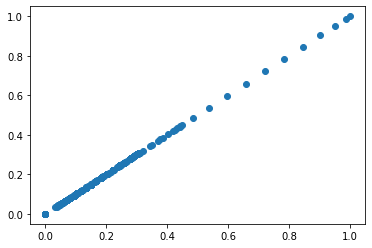

In [ ]:
from matplotlib import pyplot
pyplot.scatter(chol_1.flatten(), chol_2.flatten())

In [ ]:
K=10
M=100
diag=numpy.ones(K)
num_offdiag=int(((K-1)**2+K-1)/2)+(M-K)*K
offdiag=scipy.stats.norm.rvs(0,.01, size=num_offdiag)
chol=construct_K_rank_cholesky(diag, offdiag,M,K)

In [ ]:
# offdiag=scipy.stats.beta.rvs(20,20, size=num_offdiag)*2-1
offdiag=scipy.stats.norm.rvs(0,10, size=num_offdiag)

corrchol=construct_K_rank_correlation_cholesky( offdiag,M,K)
offdiag2=scipy.stats.norm.rvs(0,10, size=num_offdiag)

corrchol2=construct_K_rank_correlation_cholesky( offdiag2,M,K)

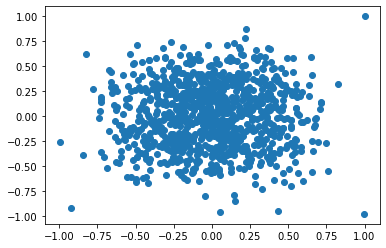

In [ ]:
pyplot.scatter(corrchol.flatten(), corrchol2.flatten())

<AxesSubplot:>

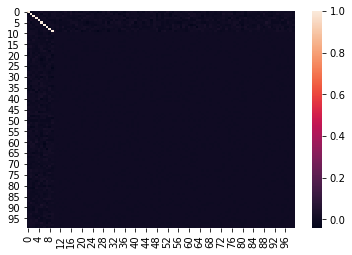

In [ ]:
seaborn.heatmap(chol@chol.T)

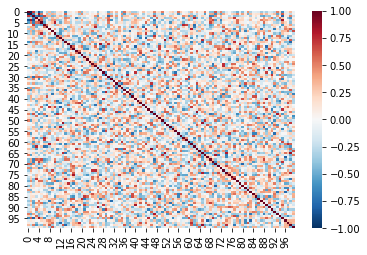

/home/mpm289/anaconda3/envs/txmap/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

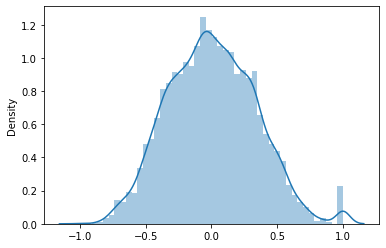

In [ ]:
corrmat=corrchol@corrchol.T
seaborn.heatmap(corrmat, vmin=-1, vmax=1, cmap='RdBu_r')
pyplot.show()
seaborn.distplot(corrmat.flatten())

A different way of writing this and that allows easier control of the correlations would be to try to explictly define the diagonal elements and the normalize the the remaining elements to ensure the sum holds.

In [ ]:
L=(numpy.sign(chol)* (chol**2/(chol**2).sum(0))**.5).T

In [ ]:
diag=scipy.stats.beta.rvs(1,1, size=K)
num_offdiag=int(((K-1)**2+K-1)/2)+(M-K)*K
offdiag=scipy.stats.norm.rvs(0,.01, size=num_offdiag)
chol=construct_K_rank_cholesky(diag, offdiag,M,K)
# L=(numpy.sign(chol)* (chol**2/(chol**2).sum(1)[:,None])**.5)
constraint=1-diag**2


In [ ]:
constraint=numpy.hstack([constraint, numpy.ones(M-K)])

In [ ]:
constraint.shape

(100,)

In [ ]:
chol_diag=jnp.zeros((M,K))


chol_diag=chol_diag.at[ jnp.diag_indices(K)].add(diag)

chol_nodiag=chol-chol_diag

In [ ]:
L=(numpy.sign(chol_nodiag)* (chol_nodiag**2/(chol_nodiag**2).sum(1)[:,None])**.5)
L=L*constraint[:,None]**.5
L=L+chol_diag
L=jnp.nan_to_num(L,nan=0)
L=L.at[0,0].add(1)

<AxesSubplot:>

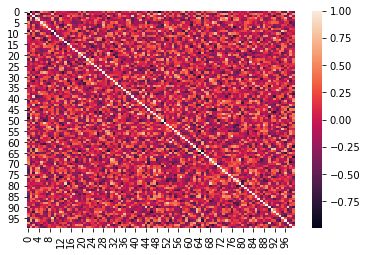

In [ ]:
seaborn.heatmap(L@L.T)

In [ ]:
(L**2).sum(1)

DeviceArray([10.        ,  1.        ,  1.        ,  1.0000001 ,
              1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  0.9999999 ,
              1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  0.9999999 ,  1.        ,  0.9999999 ,
              1.        ,  1.        ,  1.        ,  1.0000002 ,
              1.0000001 ,  1.        ,  1.        ,  0.99999994,
              1.        ,  0.9999999 ,  1.        ,  1.        ,
              1.0000001 ,  0.99999994,  0.9999999 ,  1.        ,
              0.99999994,  1.        ,  1.        ,  1.        ,
              0.99999994,  1.0000001 ,  0.99999994,  1.        ,
              1.        ,  1.        ,  1.        ,  1.        ,
              1.        ,  1.0000001 ,  1.        ,  1.        ,
              1.        ,

In [ ]:
def construct_K_rank_correlation_cholesky_diag(diag,offdiag, M,K=3):
    """
    ****
    **Arguments:**
    
    `diag` (M-1 length array)"""
    diag_vec=jnp.zeros(M)
    diag_vec=diag_vec.at[0].add(1)
    diag_vec=diag_vec.at[1:].add(diag)
    chol=construct_K_rank_cholesky(diag_vec[:K], offdiag,M,K)
    chol_diag=jnp.zeros((M,K))
    chol_diag=chol_diag.at[ jnp.diag_indices(K)].add(diag_vec[:K])
    chol_diag=chol_diag.at[0,0].multiply(0)
    chol_nodiag=chol-chol_diag

    constraint=1-diag_vec**2
    
    L=(jnp.sign(chol_nodiag)* (chol_nodiag**2/(chol_nodiag**2).sum(1)[:,None])**.5)
    L=L*constraint[:,None]**.5
    L=L+chol_diag
    L=L.at[0,0].add(1)
    return L
    
def construct_K_rank_correlation_cholesky_diag(diag,offdiag, M,K=3):
    """
    ****
    **Arguments:**
    
    `diag` (M-1 length array)"""
    diag_vec=jnp.zeros(K)
    diag_vec=diag_vec.at[0].add(1)
    diag_vec=diag_vec.at[1:].add(diag)
    chol=construct_K_rank_cholesky(diag_vec[:], offdiag,M,K)
    chol_diag=jnp.zeros((M,K))
    chol_diag=chol_diag.at[ jnp.diag_indices(K)].add(diag_vec[:])
    chol_diag=chol_diag.at[0,0].multiply(0)
    chol_nodiag=chol-chol_diag

    constraint=1-diag_vec**2
    constraint=jnp.hstack([constraint, jnp.ones(M-K)])

    print (constraint)
    print (chol_diag)
    
    L=(jnp.sign(chol_nodiag)* (chol_nodiag**2/(chol_nodiag**2).sum(1)[:,None])**.5)
    L=jnp.nan_to_num(L,nan=0)
    L=L*constraint[:,None]**.5
    L=L+chol_diag

    L=L.at[0,0].add(1)
    return L

In [ ]:
# offdiag=scipy.stats.norm.rvs(0,10, size=num_offdiag)
# offdiag=scipy.stats.beta.rvs(100,100, size=num_offdiag)*2-1
offdiag=jnp.zeros(num_offdiag)
# diag=scipy.stats.beta.rvs(100,100, size=K-1)
diag=jnp.ones(K-1)/2
corrchol=construct_K_rank_correlation_cholesky_diag( diag,offdiag,M,K)
corrchol@corrchol.T

[0.   0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.  ]
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.

DeviceArray([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
             [0.  , 0.25, 0.  , ..., 0.  , 0.  , 0.  ],
             [0.  , 0.  , 0.25, ..., 0.  , 0.  , 0.  ],
             ...,
             [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
             [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
             [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)

<AxesSubplot:>

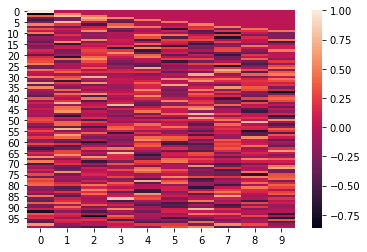

In [ ]:
seaborn.heatmap(corrchol)

<AxesSubplot:>

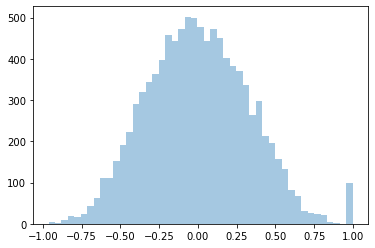

In [ ]:
seaborn.distplot((corrchol@corrchol.T).flatten(), kde=False)

<AxesSubplot:>

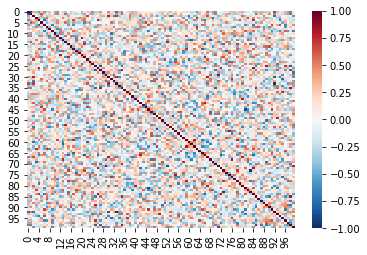

In [ ]:
seaborn.heatmap(corrchol@corrchol.T,vmin=-1, vmax=1, cmap='RdBu_r')

In [ ]:
U=scipy.stats.norm.rvs(0, 1, size=(K,20000))

In [ ]:
X=(chol@U)

<AxesSubplot:>

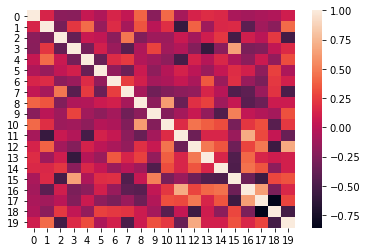

In [ ]:
seaborn.heatmap(numpy.corrcoef(L@U))

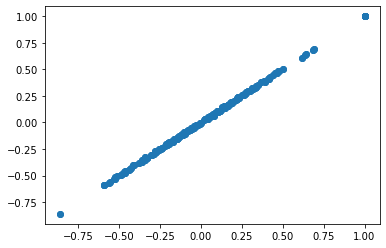

In [ ]:
pyplot.scatter(numpy.corrcoef(L@U).flatten(), (L@L.T).flatten())

In [ ]:
corr=numpy.corrcoef(X)


In [ ]:
corr_chol=numpy.linalg.cholesky(corr)

In [ ]:
# corr_chol

In [ ]:
numpy.diag(corr_chol)

array([1.        , 0.93008319, 0.35836398, 0.46380276, 0.76057682,
       0.39024213, 0.55888418, 0.35678557, 0.38854467, 0.32247046,
       0.37536283, 0.38052384, 0.26908876, 0.37694467, 0.24136332,
       0.20083782, 0.23339774, 0.19450971, 0.16844581, 0.27697286])

In [ ]:
from functools import partial

@partial(jit, static_argnums=(1,2))
def construct_K_rank_correlation_cholesky( offdiag, M,K=3):
    """A cholesky matrix that defines correlation (rather than covariance) matrices"""
    chol=jnp.zeros((M,K))
    tri_max=compute_triangle_size(K)

#     chol=chol.at[ jnp.diag_indices(K)].add(diag)
    chol=chol.at[jnp.tril_indices(K, -1,)].add(offdiag[:tri_max])

    x_ind=jnp.repeat(jnp.arange(K,M), repeats=K)
    y_ind=jnp.tile(jnp.arange(0,K),M-K)

    chol=chol.at[x_ind, y_ind].add(offdiag[tri_max:])
    L=jnp.zeros(chol.shape)
    L.at[0,0].add(1)
    for i in range(0, M):
        L_j_sum=0
        j=0
        for j in range(min(i,K-1)):
            L=L.at[i,j].add(chol[i,j]*(1-L_j_sum))
            L_j_sum=L_j_sum+L[i,j]**2
        L=L.at[i,j+1].add((1-L_j_sum)**.5)
#         print (L_j_sum)
#         print (chol[i,2])
        
#     L_ii=(1-(L**2).sum(1))
# #     print (A_ii)
#     for i in range(M):
#         L=L.at[i,i].add(L_ii[i])

    return L

SyntaxError: 'return' outside function (<ipython-input-13-bbeaca4e6299>, line 33)

In [ ]:
from functools import partial

@partial(jit, static_argnums=(1,2))
def construct_K_rank_correlation_cholesky( offdiag, M,K=3):
    """A cholesky matrix that defines correlation (rather than covariance) matrices"""
    chol=jnp.zeros((M,K))
    tri_max=compute_triangle_size(K)

#     chol=chol.at[ jnp.diag_indices(K)].add(diag)
    chol=chol.at[jnp.tril_indices(K, -1,)].add(offdiag[:tri_max])

    x_ind=jnp.repeat(jnp.arange(K,M), repeats=K)
    y_ind=jnp.tile(jnp.arange(0,K),M-K)

    chol=chol.at[x_ind, y_ind].add(offdiag[tri_max:])
    L=[]
    for i in range(0, M):
        L.append([])
        L_j_sum=0
        j=0
        for j in range(min(i,K-1)):
            L[-1].append(chol[i,j]*(1-L_j_sum))
            L_j_sum=L_j_sum+L[-1][-1]**2
        L[-1].append((1-L_j_sum)**.5)
#         print (L_j_sum)
#         print (chol[i,2])
        
#     L_ii=(1-(L**2).sum(1))
# #     print (A_ii)
#     for i in range(M):
#         L=L.at[i,i].add(L_ii[i])

    return L

In [ ]:
from functools import partial

@partial(jit, static_argnums=(1,2))
def construct_K_rank_correlation_cholesky( offdiag, M,K=3):
    """A cholesky matrix that defines correlation (rather than covariance) matrices"""
    chol=jnp.zeros((M,K))
    tri_max=compute_triangle_size(K)

#     chol=chol.at[ jnp.diag_indices(K)].add(diag)
    chol=chol.at[jnp.tril_indices(K, -1,)].add(offdiag[:tri_max])

    x_ind=jnp.repeat(jnp.arange(K,M), repeats=K)
    y_ind=jnp.tile(jnp.arange(0,K),M-K)

    chol=chol.at[x_ind, y_ind].add(offdiag[tri_max:])
    L=[]
    for i in range(0, M):
        L.append([])
        L_j_sum=0
        j=0
        for j in range(min(i,K-1)):
            L[-1].append(chol[i,j]*(1-L_j_sum))
            L_j_sum=L_j_sum+L[-1][-1]**2
        L[-1].append((1-L_j_sum)**.5)
#         print (L_j_sum)
#         print (chol[i,2])
        
#     L_ii=(1-(L**2).sum(1))
# #     print (A_ii)
#     for i in range(M):
#         L=L.at[i,i].add(L_ii[i])

    return L

In [ ]:

M=50
K=50
diag=numpy.ones(K)
num_offdiag=int(((K-1)**2+K-1)/2)+(M-K)*K
offdiag=scipy.stats.beta.rvs(1,1, size=compute_triangle_size(K))*2-1
chol=construct_K_rank_cholesky(jnp.zeros(M),offdiag,M,K)

In [ ]:
chol=construct_K_rank_correlation_cholesky(offdiag,M,K)

In [ ]:
(chol**2)

DeviceArray([[0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.03637181, 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.00165718, 0.08752793, 0.        , ..., 0.        ,
              0.        , 0.        ],
             ...,
             [0.9839438 , 0.2771371 , 0.9832764 , ..., 0.        ,
              0.        , 0.        ],
             [0.04209985, 0.26241285, 0.15109105, ..., 0.26683936,
              0.        , 0.        ],
             [0.6540525 , 0.10863848, 0.00787414, ..., 0.00324894,
              0.04741142, 0.        ]], dtype=float32)

In [ ]:
(chol**2).sum(1)

DeviceArray([1.        , 0.99999994, 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.0000001 , 1.        , 1.        ,
             0.99999994, 1.        , 1.        , 1.0000001 , 1.        ,
             1.        , 1.        , 1.        , 0.9999999 , 1.0000001 ],            dtype=float32)

<AxesSubplot:>

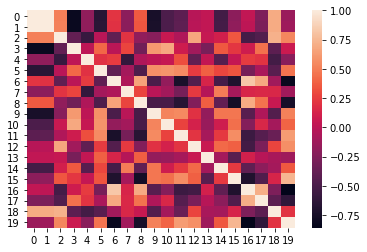

In [ ]:
seaborn.heatmap(chol@chol.T)

If we want to restrict the Cholesky matrix such that $A=LL^T$ only generates correlation matrices ($A_{ii}=1$). The diagonal entries of the Cholesky matrix satisfy

$$L_ii=\sqrt{A_{ii} - \sum_{j=1}^{i-1} L_{ij}^2}$$

and the terms inside the square root must be positive. If we add the constraint that all $A_{ii}=1$, then we're requiring that

$$\sum_{j=1}^{i-1} L_{ij}^2<1$$

If we define a triangle matrix $M$, where

$$M_{ij} \in (-1,1), \qquad i>j, \quad i>1$$

we can construct $L$ such that it satisfies the constraint by defining

$$L_{ij}=M_{ij}\left(1- \sum_{k=1}^{j-1} L_{ik}^2 \right)$$

In [ ]:
M=200
K=30
diag=numpy.ones(K)
num_offdiag=int(((K-1)**2+K-1)/2)+(M-K)*K
offdiag=scipy.stats.beta.rvs(2,2, size=num_offdiag)*2-1
# offdiag=scipy.stats.norm.rvs(0,.7, size=num_offdiag)

chol=construct_K_rank_correlation_cholesky(offdiag,M,K)

In [ ]:
chol=construct_K_rank_correlation_cholesky(offdiag,M,K)

In [ ]:
chol

DeviceArray([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [ 0.21982151,  0.9755401 ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [-0.56195927,  0.105765  ,  0.82037526, ...,  0.        ,
               0.        ,  0.        ],
             ...,
             [-0.4945506 ,  0.24465117,  0.35998127, ..., -0.03192285,
              -0.0381896 ,  0.37879407],
             [ 0.4406563 ,  0.5379989 ,  0.02141716, ...,  0.09577936,
               0.04561179,  0.37971914],
             [-0.59339374,  0.2975945 ,  0.04481918, ...,  0.0099012 ,
               0.03863211,  0.36207256]], dtype=float32)

In [ ]:
(chol**2).sum(1)

DeviceArray([1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 0.99999994, 1.0000001 ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 0.99999994, 1.        , 0.9999999 , 1.        ,
             1.0000002 , 0.9999999 , 1.0000001 , 1.        , 1.        ,
             0.9999999 , 0.99999994, 0.99999994, 0.9999999 , 1.        ,
             1.        , 1.        , 1.0000001 , 1.        , 0.99999994,
             0.99999994, 1.        , 0.9999999 , 1.0000001 , 0.99999994,
             0.9999998 , 1.0000002 , 1.        , 1.        , 1.        ,
             1.0000001 , 0.99999994, 1.        , 0.9999999 , 1.0000001 ,
             1.        , 1.        , 1.        , 0.9999999 , 0.9999999 ,
             1.        , 1.        , 0.99999994, 0.99999994, 0.99999994,
             0.99999994, 1.        , 1.        , 1.

<AxesSubplot:>

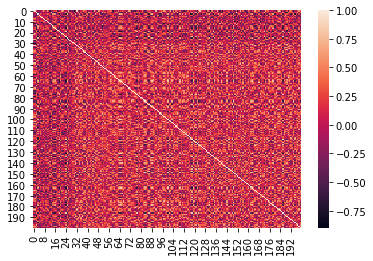

In [ ]:
seaborn.heatmap(chol@chol.T)

In [ ]:
#export
@jit
def factor_toeplitz(U, eps=1e-6):
    """Factor a symmetric Toeplitz covariance matrix.
        
    **Arguments:**

            U(numpy.array): The first row of the covariance matrix

    **Returns:**

            triu: The upper triangular Cholesky matrix"""
    #initialize
    U=U.at[0].set(1+eps)
    u_k=U/U[0]**.5
    v_k=U/U[0]**.5
    v_k=v_k.at[0].set(0)
    
    Us=[u_k]
    
    for k in range(0,len(U)-1):
        # Find the right rotation
        sin_k=v_k[k+1]/u_k[k]
        cos_k=(1-sin_k**2)**.5
        #Shift u_k
        Zu=jnp.zeros(len(u_k))
#         Zu[1:]=u_k[:-1]
        Zu=Zu.at[1:].set(u_k[:-1])
        
        u_k=((Zu-sin_k*v_k)/cos_k)
        v_k=(-sin_k*u_k+cos_k*v_k)
        Us.append(u_k)
    return jnp.array(Us)

### Matrix constructiong

In [ ]:
#export
def is_triangle(x):
    """Check whether a x is a triangular number, defined as x=(k^2+k)/2, where k is an integer."""
    result=.5*(8*x+1)**.5-.5
#     print (result)
    return result==int(result)
def triangle_base(x):
    """Check whether a x is a triangular number, defined as x=(k^2+k)/2, where k is an integer."""
    result=.5*(8*x+1)**.5-.5
    assert result==int(result), ValueError("x is a not a triangle number.")
    return result
def array2tril(array,k=-1):
    """Converts an array into a lower triangle matrix. The length of the input array must be a triangle number
    defined as x=(k^2+k)/2, where k is an integer.
        Arguments
            array - The array from which to build the triangle matrix.
            k (integer, less than or equal to zero) - The offset relative to diagonal above which values of the
            triangle matrix will be zero."""
    try:
        tri_base=triangle_base(len(array))
    except:
        raise(ValueError("The input array cannot be coerced into a triangle"))
    assert k<=0, 'k must be <=0'

    m=int(tri_base)-k
    tril=jnp.zeros((m,m))
#     print (tril)
    tril_ind=jnp.tril_indices(m,k)
    return jax.ops.index_update(tril, tril_ind, array)
#     pass

In [ ]:
test=jnp.ones(10)

In [ ]:
chol_nodiag=array2tril(test, -1)

AttributeError: module 'jax.ops' has no attribute 'index_update'

In [ ]:
chol_nodiag

In [ ]:
#export
def update_diag(array, diag):
    """Update the diagonal elements of a 2D-array
        Arguments
            array (M-by-M array) - The array whose diagonal will be updated
            diag (M-length array) - The new values of the diagonal"""
    diag_ind=jnp.diag_indices(len(diag))
    return jax.ops.index_update(array, diag_ind, diag)
    

In [ ]:
update_diag(chol_nodiag,numpy.ones(5)*2)

In [ ]:
#export
def construct_cholesky(offdiag_elements, diag_elements):
    """Build a cholesky matrix from a list of offdiagonal and diagonal elements
        Arguments
            offdiag_elements (array of floats) - The array of elements below the diagonal. For an M-by-M Cholesky
                matrix, should be ((M-1)^2+M-1)/2 elements long.
            diag_elements (array of strictly positive floats) - the diagonal elements. For an M-by-M Cholesky
                matrix, should be M elements long."""
    chol_nodiag=array2tril(offdiag_elements, -1)
    return update_diag(chol_nodiag,diag_elements)

In [ ]:
offdiag=scipy.stats.norm.rvs(0,1, size=10)
diag=2.**scipy.stats.norm.rvs(0,1, size=5)
chol=construct_cholesky(offdiag, diag)

In [ ]:
z=scipy.stats.norm.rvs(0,1, size=(5,1))

In [ ]:
x=numpy.matmul(chol, z)

In [ ]:
cov=numpy.cov(x)

In [ ]:
seaborn.heatmap(cov, annot=True)

In [ ]:
seaborn.heatmap(numpy.matmul(chol,chol.T), annot=True)

In [ ]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x))

### Special functions

#### The log-gamma function

The gamma function occurs frequently in probability distributions, however the JAX implementation seems slower than I would like. Switching from a Poisson to Negative Binomial distribution, slows the log-evidence computations down by about half. So, I want a good approximations that's faster than the current JAX function. The gamma function generalizes the factorial operation from integers to real numbers. The factorial is defined

$$k!=\prod_{i=1}^k k$$
with $0!$ defined as
$$0! = 1$$

For positive integers:

$$\Gamma(k+1)=k!$$

In general, it's better to work with the logarithms of these functions for numerical stability. So let's define the log-gamma function as

$$L(k)=ln \Gamma(k)$$

The gamma function, like the factorial, follows a recurrence


$$\Gamma(k+1)=k\Gamma(k)$$

and

$$L(k+1)=L(k) + ln(k)$$


We want to compute efficiently. To do this, we'll make use of two tricks:

1. A second-order approximation of the log-gamma function that works well when $k>2$

and

2. The recurrence relationship, which we'll use to extend the approximation to $0<k \leq 2$

In [ ]:
#export
@jit
def gammaln(x):
    """Returns the log of the gamma function computed in a numerically stable manner. This is accomplished uisng two tricks
    1. A second-order approximation of the log-gamma function that works well when $k>2$

        and

    2. The recurrence relationship L(x+1)=L(x)+ln(x), which we'll use to extend the approximation to $0<k \leq 2$using a second-order Laplace approximation
    and the recurrence.
    
    That is, if we can compute L(x+1), we can obtain L(x ) =L(x+1) - ln(x)."""
    def gammaln_offset_1(x):
        stirlings_approx=jnp.nan_to_num(jnp.log(x)*(x-.5)-x+.5*jnp.log(2*pi))
        return (stirlings_approx+jnp.log(1.+1/(x*12)))
    return jnp.nan_to_num(gammaln_offset_1(x+1))-jnp.log(x)

A good approximation of the factorial for large $k$ is derived from the second-order Laplace approximation

$$k! = \sqrt{2\pi k}\left(\frac{k}{e} \right)^k\left(1+\frac{1}{12k}\right)$$



$$L(k+1) = ln (k!) \sim ln(k)(.5+k)-k + ln(2 \pi) +ln \left(1 +\frac{1}{12k}\right)$$

or 

$$L(k) \sim ln(k-1)(k-.5)-k + 1 + ln(2 \pi) +ln \left(1 +\frac{1}{12k-12}\right)$$

This approximation is generally quite good for larger values of $k$:

In [ ]:
@jit
def gammaln_exact(x):
    return jnp.nan_to_num(jsc.special.gammaln(x))



def gammaln_laplace(x):
    stirlings_approx=jnp.nan_to_num(jnp.log(x-1)*(x-.5)-x+1+.5*jnp.log(2*pi))
    return (stirlings_approx+jnp.log(1.+1/(x*12-12)))  #jsc.special.xlog1py(1,1/(x*12)))



In [ ]:
pyplot.figure(figsize=(12,4))
pyplot.subplot(121)
X=numpy.linspace(.01,5, 100)
pyplot.plot(X, gammaln_exact(X), c='b', label='Exact')
pyplot.plot(X, gammaln_laplace(X), c='r', label='Laplace')
pyplot.legend()
pyplot.ylabel('Function value')
pyplot.xlabel('k')
pyplot.subplot(122)
X=numpy.logspace(-2,5, 1000)
# pyplot.plot(X, , c='b', label='exact')
pyplot.plot(X,gammaln_exact(X)- gammaln_laplace(X), c='r')
pyplot.ylabel('Exact - Laplace Approximation')
pyplot.xlabel('k')

pyplot.xscale('symlog')

So, the approximation is very good for $k>2$, but once $k$ approaches $1$ the Laplace approximation becomes poor. However, the gamma function has a useful recurrence allows a good approximation to be extended to nearby values

$$\Gamma(k+1)=k\Gamma(k)$$

or 

$$L(k+1)=L(k) + ln(k)$$

So, if we can get a good approximation of $L(k+1)$, we can approximate

$$L(k) = L(k+1)- ln (k)$$

So,

$$L(k) \sim  ln(k)(.5+k)-k + ln(2 \pi) +ln \left(1 +\frac{1}{12k}\right) - ln(k) $$
$$L(k) \sim  ln(k)(k-.5)-k + ln(2 \pi) +ln \left(1 +\frac{1}{12k}\right) $$


In [ ]:
@jit
def gammaln_offset_1(x):
    stirlings_approx=jnp.nan_to_num(jnp.log(x)*(x-.5)-x+.5*jnp.log(2*pi))
    return (stirlings_approx+jnp.log(1.+1/(x*12)))

In [ ]:
pyplot.figure(figsize=(12,4))
pyplot.subplot(121)
X=numpy.linspace(.01,5, 100)
pyplot.plot(X, gammaln_exact(X), c='b', label='Exact')
pyplot.plot(X, gammaln_offset_1(X), c='r', label='Laplace')
pyplot.legend()
pyplot.ylabel('Function value')
pyplot.xlabel('k')
pyplot.subplot(122)
X=numpy.logspace(-2,5, 1000)
# pyplot.plot(X, , c='b', label='exact')
pyplot.plot(X,gammaln_exact(X)- gammaln_offset_1(X), c='r')
pyplot.ylabel('Exact - Laplace Approximation')
pyplot.xlabel('k')

pyplot.xscale('symlog')

This is pretty good, and improves the estimates for $k$ near 2, but because when $k$ is near one the original approximation isn't great, the new approximation is biased near zero. Whe improve this by starting from $L(k+2)$ and plugging
$$L(k+1)=L(k+2)-ln(x+1)$$
into
$$L(k) = L(k+1)- ln (k)$$

$$L(k) = L(k+2)-ln(k+1)- ln (k)$$

$$L(k) \sim  ln(k+1)(k+1-.5)-k-1 + ln(2 \pi) +ln \left(1 +\frac{1}{12k+12}\right)- ln (k) $$

So

$$\Gamma(k)=e^{L(k)} \sim exp \left[ ln(k+1)(k+1-.5)-k-1 + ln(2 \pi) +ln \left(1 +\frac{1}{12k+12}\right)- ln (k) \right] $$

$$e^{ln(k+1)}e^{(k+1-.5)} e^{-k-1} e^{ln(2 \pi)} e^{ln \left(1 +\frac{1}{12k+12}\right)} e^{-ln (k)}  $$

$$k^{-1} (k+1)^{(k+.5)} e^{-(k+1)}(2 \pi)\left(1 +\frac{1}{12k+12}\right)  $$

In [ ]:
@jit
def gammaln_offset_2(x):
    """Returns the log of the gamma function computed in a numerically stable manner using Stirling's Approximation"""
    def gammaln_offset_1(x):
        stirlings_approx=jnp.nan_to_num(jnp.log(x)*(x-.5)-x+.5*jnp.log(2*pi))
        return (stirlings_approx+jnp.log(1.+1/(x*12)))
    return jnp.nan_to_num(gammaln_offset_1(x+1))-jnp.log(x)

In [ ]:
# #export
# @jit
# def gammaln(x):
#     stirlings_approx=jnp.nan_to_num(jnp.log(x+1)*(x+.5)-x-1+.5*jnp.log(2*pi)) +jnp.log(1.+1/(x*12+12))
#     return stirlings_approx-jnp.log(x)

In [ ]:
#export
@jit
def chooseln(n,k):
    return gammaln(n+1)-gammaln(n-k+1)-gammaln(k+1)

In [ ]:
pyplot.figure(figsize=(12,4))
pyplot.subplot(121)
X=numpy.linspace(.01,5, 100)
pyplot.plot(X, gammaln_exact(X), c='b', label='Exact')
pyplot.plot(X, gammaln_offset_2(X), c='r', label='Laplace')
pyplot.legend()
pyplot.ylabel('Function value')
pyplot.xlabel('k')
pyplot.subplot(122)
X=numpy.logspace(-2,5, 1000)
# pyplot.plot(X, , c='b', label='exact')
pyplot.plot(X,gammaln_exact(X)- gammaln_offset_2(X), c='r')
pyplot.ylabel('Exact - Laplace Approximation')
pyplot.xlabel('k')

pyplot.xscale('symlog')

In [ ]:
X=numpy.linspace(1e5,1e5+.1, 1000)
pyplot.plot(X, gammaln_exact(X), c='b', label='Exact')
pyplot.plot(X, gammaln_offset_2(X), c='r', label='Laplace')

In [ ]:

@jit
def gammaln_laplace(k):
    x=k-1
    stirlings_approx=jnp.nan_to_num(jnp.log(x)*(.5+x)-x+.5*jnp.log(2*pi))
    return (stirlings_approx+jnp.log(1.+1/(x*12)))  #jsc.special.xlog1py(1,1/(x*12)))

@jit
def logfac_offset(x):

    return gammaln_laplace(x+2)-jnp.log(x+1)-jnp.log(x)

We see how good of an approximation it is over

In [ ]:
@jit
def logfactorial(x):
    return jsc.special.gammaln(x+1)
pi=jnp.pi
@jit
def logfactorial_stirling(x):
    k=x
    # return jnp.log((2*pi*k)**.5 )+k*jnp.log(k)-k
    return jnp.log(k)*(.5+k)-k+.5*jnp.log(2*pi)


@jit
def logfactorial_stirling_corr(x, bound=1):
    corr_term=1.*(x<bound)
    return logfactorial_stirling(x+corr_term)-(1-corr_term)*jnp.log(x)

def logfactorial_reduced(x):
    return jnp.log(x)*(.5+x)-x+.5*jnp.log(2*pi)
@jit
def logfactorial_eff(x):
    
    return jax.lax.cond( x<10, logfactorial, logfactorial_reduced,x)
#         return logfactorial(x)
#     else:
#         return jnp.log(x)*(.5+x)

def logfactorial_eff_array(x):
    ind=jnp.where(x<6)
    print (ind)
    return jax.lax.switch(ind, numpy.array([logfactorial, logfactorial_reduced]), x )
#         return logfactorial(x)
#     else:
#         return 
logfactorial_eff_vec=jit(jnp.vectorize(logfactorial_eff))  

In [ ]:
@jit
def logfac_2nd(x):
    return logfactorial_stirling(x)+jsc.special.xlog1py(1, 1./(12*x))

In [ ]:
@jit
def logfac_2nd_corr(x):
#     corr_term=1.*(x<1)
    correction=soft_lin(jnp.log(x),*theta[0])
    return  logfac_2nd(x)+correction


In [ ]:
domain=numpy.linspace(0,2,1000000)
pyplot.plot(domain,logfac_2nd_corr(domain), c='r')
# pyplot.plot(logfactorial_stirling(domain))
pyplot.plot(domain,logfactorial(domain))
# pyplot.xlim(0,2)

In [ ]:
domain=numpy.linspace(.0001,10,500)
pyplot.plot(numpy.log(domain), logfactorial(domain)-logfac_2nd(domain))


In [ ]:
@jit
def soft_lin(x,m, b0,b1):
    y=b1*x+b0
    return m*jax.nn.silu(y)
# def soft_lin(x,m, b0,b1):
#     y=jnp.exp(b1*x+b0)
#     return m*jsc.special.xlog1py(1,y)

Jacobian=jax.jacobian(soft_lin, (1,2,3))

def soft_lin_jac(x, m, b0, b1):
    return numpy.vstack(Jacobian(x, m,b0,b1)).T

In [ ]:
soft_lin_jac(X,-2., 1.,.5).shape

In [ ]:
X=numpy.linspace(-30,30,1000)
pyplot.plot(X, soft_lin(X,-2, 1,.5))

In [ ]:
domain=numpy.logspace(-5,5,500)
pyplot.scatter(numpy.log(domain),logfactorial(domain)-logfac_2nd(domain))

In [ ]:
from scipy import optimize

In [ ]:
domain=numpy.logspace(-3,3,500)
theta=optimize.curve_fit(f=soft_lin,xdata=numpy.log(domain), 
                   ydata=logfactorial(domain)-logfac_2nd(domain))
                    

In [ ]:
# **theta

In [ ]:
# pyplot.plot(numpy.log(domain), soft_lin(numpy.log(domain),-0.28, -4.925, -1.69), c='r')
pyplot.plot(numpy.log(domain), soft_lin(numpy.log(domain),*theta[0]), c='r')
pyplot.plot(numpy.log(domain), logfactorial(domain)-logfac_2nd(domain))


# pyplot.xscale('log')

In [ ]:
N=50000
domain=numpy.ones(N)*4
for i in tqdm(range(100000)):
    t=logfactorial(domain)

In [ ]:
N=50000
domain=numpy.ones(N)*4
for i in tqdm(range(100000)):
    t=logfactorial_stirling(domain)

In [ ]:
N=50000
domain=numpy.ones(N)*4
for i in tqdm(range(100000)):
    t=logfactorial_stirling_corr(domain)

In [ ]:
domain=numpy.arange(200)
pyplot.plot(logfactorial(domain)-logfactorial_stirling_corr(domain))

### How to efficiently approximate the log-binomial coefficient?

In [ ]:
n=100
pyplot.scatter(logfactorial_eff_vec(numpy.arange(n)), logfactorial(numpy.arange(n)))

In [ ]:
numpy.exp(logfactorial_eff_vec(numpy.ones((10,3))*3))

In [ ]:
@jit
def chooseln_exact(n,k):
    return gammaln_exact(n+1)-gammaln_exact(n-k+1)-gammaln_exact(k+1)

@jit
def chooseln(n,k):
    return gammaln_offset_2(n+1)-gammaln_offset_2(n-k+1)-gammaln_offset_2(k+1)

In [ ]:
@jit
def negative_binom_logpmf(x, mu, a=None, disp=None):
    """The negative-binomial logpdf.
        Arguments:
            x (int, >=0) - The observation
            mu (float, must be greater than 0) - The mean of the distribution
            a (float >0) - The shape parameter of the gamma distribution on the Poisson rate parameter
            disp (float >1) - The Variance/Mean of the distribution (may be easier to think about than `a`)"""
#     assert (isinstance(a, type(None))&isinstance(disp, type(None)))==False
# #     assert (isinstance(a, type(None))==False&isinstance(disp, type(None))==False)==False
#     if isinstance(disp, type(None))==False:
#         a=mu/(disp-1)
    a=mu/(disp-1)
    return (chooseln(x+a-1, x)+
            a*jnp.log(a)-
            a*jnp.log(mu+a)+
            x*jnp.log(mu)-
            x*jnp.log(mu+a))
    

In [ ]:
@jit
def negative_binom_logpmf_stirling(k, mu, a=None, disp=None):
    """The negative-binomial logpdf.
        Arguments:
            x (int, >=0) - The observation
            mu (float, must be greater than 0) - The mean of the distribution
            a (float >0) - The shape parameter of the gamma distribution on the Poisson rate parameter
            disp (float >1) - The Variance/Mean of the distribution (may be easier to think about than `a`)"""
#     assert (isinstance(a, type(None))&isinstance(disp, type(None)))==False
# #     assert (isinstance(a, type(None))==False&isinstance(disp, type(None))==False)==False
#     if isinstance(disp, type(None))==False:
#         a=mu/(disp-1)
    x=k
    a=mu/(disp-1)
    return (chooseln_stirling(x+a-1, x)+
            a*jnp.log(a)-
            a*jnp.log(mu+a)+
            x*jnp.log(mu)-
            x*jnp.log(mu+a))

In [ ]:
domain=numpy.linspace(0,100)
disp=1.5
mu=5.
a=mu/(disp-1)
print (a)
# pyplot.plot(domain, numpy.exp( negative_binom_logpmf(domain, mu,disp=disp)))
pyplot.plot(domain, numpy.exp(negative_binom_logpmf_stirling(domain, mu,disp=disp)), c='r')

In [ ]:
logfactorial_eff_vec(numpy.arange(100))

In [ ]:
# @jit
# def chooseln_eff(n,k):
#     m=n-k
#     if isinstance(n, float) or isinstance(n, int):
#         is_n_scalar=True
#     else:
#         is_n_scalar=False
        
#     if isinstance(k, float) or isinstance(k, int):
#         is_k_scalar=True
#     else:
#         is_k_scalar=False
    
#     if is_n_scalar==False:
#         n_axes=numpy.arange(len(n.shape))
#         term_n=logfactorial_eff_vec(n)
#     else:
#         term_n=logfactorial_eff(n)
        
#     if is_k_scalar==False:
#         k_axes=numpy.arange(len(k.shape))
#         term_k=logfactorial_eff_vec(k)
#     else:
#         term_k=logfactorial_eff(k)
        
#     if is_k_scalar==False or is_n_scalar==False:
#         m_axes=numpy.arange(len(m.shape))
#         term_m=logfactorial_eff_vec(m)
#     else:
#         term_m=logfactorial_eff(m)
@jit
def chooseln_eff(n,k):
    m=n-k

#     term_n=logfac_2nd_corr(n)
#     term_k=logfac_2nd_corr(k)

#     term_m=logfac_2nd_corr(m)    
    term_n=logfac_2nd(n)
    term_k=logfac_2nd(k)

    term_m=logfac_2nd(m)    
    # return logfactorial_stirling(n)-logfactorial_stirling(m)-logfactorial_stirling(k)
    return jnp.nan_to_num( term_n-term_k-term_m)#+.5*jnp.log(2*pi)-1
    # return jnp.log(m+k+1)*(m+k+2)-jnp.log(k+1)*(k+2)-jnp.log(m+1)*(m+2)+.5*jnp.log(2*pi)-1

In [ ]:
def choose_approx(n,k):
    ind_full_calc=jnp.where((n<10)&(k<10))

def chooseln_stirling_approx(n,k):
    r=.5-k/n
    ind
    # return logfactorial_stirling(n)-logfactorial_stirling(m)-logfactorial_stirling(k)
    return (jnp.log(m+k)*(.5+m+k)-jnp.log(m)*(.5+m)-jnp.log(k)*(.5+k)-.5*jnp.log(2*pi))

In [ ]:
(chooseln_stirling(40,20))

In [ ]:
N=5
domain=numpy.arange(N)
pyplot.plot(chooseln_stirling(N, domain)-chooseln(N, domain))
r=domain/200.
# pyplot.plot(  r**(.5-1) *(1-r)**(.5-1))

In [ ]:
(chooseln(40,20))

In [ ]:
chooseln_eff(100,numpy.arange(10))

In [ ]:
t=numpy.ones((5,2))

In [ ]:
t.shape

In [ ]:
from tqdm import tqdm

In [ ]:
N=50000
domain=numpy.ones(N)*4
# domain=numpy.arange(50,N-50)
for i in tqdm(range(10000)):
    t=chooseln(N,domain)


In [ ]:
N=50000
domain=numpy.ones(N)*4
for i in tqdm(range(100000)):
    t=chooseln_stirling(N,domain)

In [ ]:
fast_beta=jit(jsc.stats.beta.logpdf)

In [ ]:
N=50000
domain=numpy.ones(N)*4
for i in tqdm(range(100000)):
    t=chooseln_eff(N,domain)

In [ ]:
N=50000
domain=numpy.ones(N)*4
for i in tqdm(range(10000)):
    t=fast_beta(.99,N,domain)

In [ ]:
def logbeta(a,b):
    F=fast_beta(10,a ,b)
    return (a-1)*

In [ ]:
N=10
domain=numpy.linspace(0,N,1000)

N_array=numpy.ones(len(domain))*N
pyplot.plot((chooseln(N_array,domain)), c='r')
pyplot.plot((chooseln_stirling(N_array,domain)), c='b')
pyplot.plot((chooseln_eff(N_array,domain)), c='g')

In [ ]:
N=50000
domain=numpy.arange(50,N-50)
for i in tqdm(range(10000)):
    t=nchoosek_ln(N,domain)

In [ ]:
def chooseln_eff(n,k):
    if isinstance(n, float) or isinstance(n, int):
        is_n_scalar=True
    else:
        is_n_scalar=False
        
    if isinstance(k, float) or isinstance(k, int):
        is_k_scalar=True
    else:
        is_k_scalar=False
    
    if is_n_scalar==True and is_k_scalar==True:
        pass
    elif is_n_scalar==True and is_k_scalar==False:
        pass
    elif is_n_scalar==False and is_k_scalar==True:
        pass
    else:
        pass